# Pandas API on Spark

`pandas` is a Python library for data analysis. It offers a number of data exploration, cleaning and transformation operations that are critical in working with data in Python. _But Pandas code can only run on a single machine, so it does not scale out_, so if you are processing a large dataset with Pandas - it will be very slow, and you will most likely get an out of memory error.

Even though Spark SQL provides a programming abstraction called DataFrame that is similar in some ways to Pandas DataFrames, they are not compatible and existing Pandas code cannot be reused. Also, PySpark syntax is very different from the Pandas syntax making it harder to for data scientists to migrate their scripts to scale out an existing Pandas codebase.

On April 24, 2019, Databricks announced a new open-source project named Koalas which aimed at providing the Pandas API on top of Spark. This library gathered momentum and was officially merged into PySpark in Spark 3.2 release (October 2021) and named the __Pandas API on Spark__ (`pyspark.pandas` module). The Pandas API on Spark has the same syntax as Pandas but it uses a PySpark DataFrame under the hood.

<img src="images/ps.png" style="background:none; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

It means you can do almost everything you used to do with Pandas, as more than 80% of Pandas functions are available in Pandas API on Spark.

## Pandas on Spark benefits

- __Pandas-like API__: It allows users to utilize methods and functions that resemble Pandas DataFrame operations, making it easier for those familiar with Pandas to transition to working with PySpark DataFrames.
- __Unified Syntax__: It offers a similar syntax and functionality to Pandas, enabling data engineers and scientists to apply their knowledge of Pandas operations directly to distributed datasets within the Spark ecosystem.
- __Performance Enhancements__: While maintaining a Pandas-like interface, it is optimized for distributed computing. It leverages Spark's distributed architecture, improving performance for large-scale data processing tasks that cannot fit into a single machine's memory.
- __Interoperability__: It supports seamless conversion between Pandas DataFrames and PySpark DataFrames, facilitating bidirectional operations to convert to a Pandas DataFrame and to convert back to a PySpark DataFrame.
- __Data Manipulation__: Users can perform various data manipulation tasks such as filtering, aggregations, joins, and transformations using Pandas-like syntax within the PySpark environment.

Having a PySpark DataFrame under the hood allows Pandas on Spark Dataframe to be converted from/to a PySpark DataFrame. So if you cannot find the function that you need, you can do the following:

1. Transform the Pandas on Spark Dataframe into a PySpark DataFrame
2. Perform multiple transformations using PySpark API
3. Convert the PySpark DataFrame back into a Pandas on Spark Dataframe

# Bridge between Pandas and PySpark

When a Pandas on Spark Dataframe is created, an _Internal Frame_ and a PySpark Dataframe are also created.

<img src="images/internal.png" style="background:none; border:none; box-shadow:none; display:inline; margin:0; vertical-align:middle;" width="50%">

The _Internal Frame_ provides conversions between the Pandas Dataframe and the PySpark Dataframes. It keeps metadata like the column mapping between the 2 dataframes or the index.

It allows Pandas on Spark Dataframe to support Pandas functionalities that are not supported by PySpark dataframes:

- __Mutable syntax__: You don’t have to create a new dataframe each time you want to modify it.
- __Sequential index__: You can use Pandas functionalities based on an index.
- __Pandas dtypes__.

## Indexing

Unlike PySpark Dataframe, Pandas on Spark Dataframe replicate the indexing functionality of Pandas, e.g., index columns are used to access rows by `loc`/`iloc` indexers or to match corresponding rows for operations combining two DataFrames or Series (for example `df1 + df2`), and so on.

When you create a Pandas on Spark Dataframe you can set a column of the dataframe as the index column. If you did not specify any index column, the default index will be used.

There are3 types of indexes:

- __Sequence__: This is the index type used by default. It implements a sequence that increases one by one. This is very likely to move all the dataframe into a single node which will be slow and probably raise an OOM error. As a result, you should not use it when the dataset is large.
- __Distributed-sequence__: It implements a sequence that increases one by one in a distributed manner. If your dataset is large and you need a sequential index, you should use this index type. 

> Note: If more data are added to the data source after creating this index, then it does not guarantee the sequential index.

- __Distributed__: It implements a monotonically increasing sequence, but not consecutive (e.g. 1, 8, 12) and the values are not deterministic. So it does not replicate Pandas indexing at all. Performance-wise, this is the best index type but it cannot be used for computing operations between two dataframes. Indeed, to do that the 2 dataframes must have the same indexes and it is not guaranteed because of indeterministic index values.

|                                 | Sequence (_default_) | Distributed sequence | Distributed |
| --------------------------------- | ------------------------------- | -------------------- | ----------- |
| Distributed computation                                            | __No__, in a single worker node                                | Yes                                      | Yes                    |
| Performance                                                        | __Bad for large dataset__                                      | _Good enough_                            | Good                   |
| Sequential indexing                                                | Yes                                                            | Yes                                      | __No__                 |
| Operation on different dataframes                                  | Yes                                                            | Yes                                      | __No__                 |


# Pandas on Spark best practices

## Avoid computation on a single partition

If you start using the Pandas on Spark API you will probably get this warning:

```
Moving all data to a single partition, this can cause serious performance degradation
```

This happens in several cases:

- Whenever an index is needed but there is no index column and default_index is set to sequential type. A very common example is when a PySpark Dataframe is converted into a Pandas on Spark Dataframe using `to_pandas_on_spark()`.
- When using a function (e.g., `rank`) which implementation uses PySpark’s Window without specifying partition specification.

> Note: This is clearly mentioned in the documentation.

## Do not use the sequential default index

You should set the default index to distributed or distributed-sequence to avoid computation on a single partition.

```python
import pyspark.pandas as ps
ps.set_option('compute.default_index_type', 'distributed-sequence')
```

## Try to specify the index column whenever an index is required
Using an existing column as an index column is always faster than using any of the three default indexes because there is some overhead to create a default index.

E.g., when a PySpark Dataframe is converted into a Pandas on Spark Dataframe you should specify the index column:

```python
df.to_pandas_on_spark(index_col="Col1")
```

## Remember that the data is distributed
Since the data is distributed, some functions like `sort_values` require to move the data across all worker nodes. This is called _Shuffle_ and it will slow down a lot the execution of your code. So you should try to use this kind of function as little as possible.

You can use the `spark.explain()` to show the Physical Plan and detect whether there is a _Shuffle_.

# Working with Pandas on Spark

Before we start, let's install and import essential libraries.

In [3]:
%%capture
%pip install pandas plotly pyarrow

In [1]:
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", "is_categorical_dtype")

/Users/dima/Development/PyCharmProjects/PythonRetrain/venv/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
number_cores = 2
memory_gb = 4

spark = (SparkSession
    .builder
    .appName('Pandas on Spark')
    .master(f"local[{number_cores}]")
    .config("spark.driver.memory", f"{memory_gb}g")
    # override default hostname taken from system
    # to show fancy UI
    .config("spark.driver.host", "localhost")
    .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/18 12:59:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Creating a Pandas Dataframe is simple:

In [3]:
psdf = ps.DataFrame(
    {'a': [1, 2, 3, 4, 5, 6],
     'b': [100, 200, 300, 400, 500, 600],
     'c': ["one", "two", "three", "four", "five", "six"]},
    index=[10, 20, 30, 40, 50, 60])
psdf

a    b      c
10  1  100    one
20  2  200    two
30  3  300  three
40  4  400   four
50  5  500   five
60  6  600    six

In [4]:
psdf.head()

a    b      c
10  1  100    one
20  2  200    two
30  3  300  three
40  4  400   four
50  5  500   five

Converting to/from _pure_ pandas dataframes:

In [5]:
pddf = psdf.to_pandas()

Let us find out the type of dataframes

In [6]:
type(pddf), type(psdf)

(pandas.core.frame.DataFrame, pyspark.pandas.frame.DataFrame)

In [7]:
psdf_ = ps.from_pandas(pddf)
type(psdf_)

pyspark.pandas.frame.DataFrame

Sometimes, we have to convert spark dataframes to `pyspark.pandas` dataframes and vice versa. It is also pretty straightforward:

In [8]:
dates = pd.date_range('20240101', periods=6)
pdf = pd.DataFrame(np.random.randn(6, 4), index=dates, columns=list('ABCD'))
pdf

A         B         C         D
2024-01-01  1.202380  0.212296 -0.531927  0.890799
2024-01-02 -0.568805 -0.028098 -0.446181 -1.535313
2024-01-03 -0.836389 -0.336269 -0.509754  1.068940
2024-01-04 -1.039800 -0.912460 -0.063611 -0.412508
2024-01-05 -0.549617 -0.410541  0.019848 -0.770269
2024-01-06  0.784404  2.192180  0.733494 -0.216853

Create Spark Dataframe using Pandas dataframe:

In [9]:
sdf = spark.createDataFrame(pdf)
type(sdf)

pyspark.sql.dataframe.DataFrame

In [10]:
sdf.show()

+-------------------+--------------------+--------------------+-------------------+
|                  A|                   B|                   C|                  D|
+-------------------+--------------------+--------------------+-------------------+
|  1.202379896368542|  0.2122962199232617| -0.5319271308806955| 0.8907986695822314|
|-0.5688047021943095| -0.0280982906964395|-0.44618148555823706|-1.5353126297359228|
|-0.8363891801441049|-0.33626939871564815| -0.5097543527651075| 1.0689404168592993|
|-1.0398002373058712| -0.9124604544095205|-0.06361097894055978| -0.412508429091405|
|-0.5496167572772984| -0.4105408686569245|0.019848330853203994|-0.7702685791612506|
| 0.7844035966727451|   2.192179706241367|  0.7334936979077156|-0.2168527520575025|
+-------------------+--------------------+--------------------+-------------------+



In [13]:
psdf = sdf.to_pandas_on_spark()
type(psdf)

pyspark.pandas.frame.DataFrame

In [14]:
psdf.head()

A         B         C         D
0  1.202380  0.212296 -0.531927  0.890799
1 -0.568805 -0.028098 -0.446181 -1.535313
2 -0.836389 -0.336269 -0.509754  1.068940
3 -1.039800 -0.912460 -0.063611 -0.412508
4 -0.549617 -0.410541  0.019848 -0.770269

In [55]:
from pyspark.pandas import option_context
with option_context(
        "compute.default_index_type", "distributed-sequence"):
    psdf = sdf.to_pandas_on_spark()

type(psdf)

pyspark.pandas.frame.DataFrame

In [15]:
psdf.head()

A         B         C         D
0  1.202380  0.212296 -0.531927  0.890799
1 -0.568805 -0.028098 -0.446181 -1.535313
2 -0.836389 -0.336269 -0.509754  1.068940
3 -1.039800 -0.912460 -0.063611 -0.412508
4 -0.549617 -0.410541  0.019848 -0.770269

Similar to pandas, `pyspark.pandas` can use the standard Pandas functionalities.

In [16]:
psdf = ps.DataFrame({'A': ['foo', 'bar', 'foo', 'bar',
                          'foo', 'bar', 'foo', 'foo'],
                    'B': ['one', 'one', 'two', 'three',
                          'two', 'two', 'one', 'three'],
                    'C': np.random.randn(8),
                    'D': np.random.randn(8)})

In [17]:
psdf['A']  # or psdf.A

0    foo
1    bar
2    foo
3    bar
4    foo
5    bar
6    foo
7    foo
Name: A, dtype: object

In [18]:
psdf[['A', 'B']]

A      B
0  foo    one
1  bar    one
2  foo    two
3  bar  three
4  foo    two
5  bar    two
6  foo    one
7  foo  three

In [19]:
psdf.loc[1:2]

A    B         C         D
1  bar  one  1.687102  0.205941
2  foo  two -1.246417  1.067271

In [20]:
psdf.iloc[:3, 1:2]

B
0  one
1  one
2  two

In [21]:
psdf.groupby('A').sum()

C         D
A                      
bar -1.148182  3.293928
foo  0.608002  2.566827

In [22]:
psdf.groupby(['A', 'B']).sum()

C         D
A   B                        
foo one    1.030333  0.017819
    two   -1.089448  2.781289
bar three -1.416955  1.352151
    one    1.687102  0.205941
foo three  0.667118 -0.232281
bar two   -1.418329  1.735837

Applying Python function with Pandas on Spark object:

In [23]:
psdf.apply(np.cumsum)

A                             B         C         D
0                       foo                           one  0.960210 -0.873854
1                    foobar                        oneone  2.647312 -0.667913
2                 foobarfoo                     oneonetwo  1.400894  0.399357
3              foobarfoobar                oneonetwothree -0.016061  1.751508
4           foobarfoobarfoo             oneonetwothreetwo  0.140909  3.465526
5        foobarfoobarfoobar          oneonetwothreetwotwo -1.277420  5.201363
6     foobarfoobarfoobarfoo       oneonetwothreetwotwoone -1.207298  6.093036
7  foobarfoobarfoobarfoofoo  oneonetwothreetwotwoonethree -0.540180  5.860755

In [24]:
psdf[['A', 'B']].apply(np.cumsum, axis=1)

A         B
0  foo    fooone
1  bar    barone
2  foo    footwo
3  bar  barthree
4  foo    footwo
5  bar    bartwo
6  foo    fooone
7  foo  foothree

In [25]:
psdf[['C', 'D']].apply(lambda x: x ** 2)

C         D
0  0.922003  0.763622
1  2.846312  0.042412
2  1.553556  1.139067
3  2.007761  1.828311
4  0.024639  2.937859
5  2.011657  3.013129
6  0.004917  0.795081
7  0.445046  0.053955

In [26]:
def square(x) -> ps.Series[float]:
    return x ** 2

In [27]:
psdf[['C', 'D']].apply(square)

/Users/dima/Development/PyCharmProjects/PythonRetrain/venv/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/dima/Development/PyCharmProjects/PythonRetrain/venv/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


C         D
0  0.922003  0.763622
1  2.846312  0.042412
2  1.553556  1.139067
3  2.007761  1.828311
4  0.024639  2.937859
5  2.011657  3.013129
6  0.004917  0.795081
7  0.445046  0.053955

Though some operations might not work as expected, depending on data size.

E.g., working properly since `size of data <= compute.shortcut_limit` (1000)

In [33]:
ps.DataFrame({'A': range(1000)}).apply(lambda col: col.max())

A    999
dtype: int64

Not working properly since `size of data > compute.shortcut_limit` (1000)

In [28]:
ps.DataFrame({'A': range(1001)}).apply(lambda col: col.max())

/Users/dima/Development/PyCharmProjects/PythonRetrain/venv/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/dima/Development/PyCharmProjects/PythonRetrain/venv/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


A     499
A    1000
dtype: int64

But you can modify the setting:

In [29]:
ps.set_option('compute.shortcut_limit', 1001)
ps.DataFrame({'A': range(1001)}).apply(lambda col: col.max())

A    1000
dtype: int64

## Plots
You can also use Pandas on Spark API to generate interactive plots.

pandas uses matplotlib by default, which provides static plot charts. For example, the codes below generates a static chart:

<Axes: >

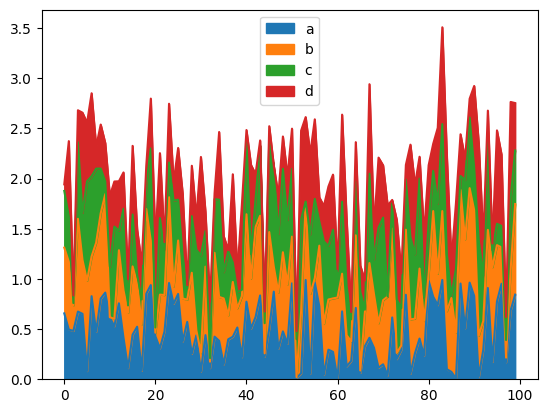

In [64]:
%matplotlib inline

pd.DataFrame(
    np.random.rand(100, 4), columns=list("abcd")).plot.area()

In contrast, the Pandas on Spark uses a plotly backend by default, which provides interactive charts. For example, it allows users to interactively zoom in and out. Based on the type of plot, the pandas API on Spark automatically determines the best way to execute the computation internally when generating interactive charts:

In [66]:
ps.DataFrame(np.random.rand(100, 4), columns=list("abcd")).plot.area()

In [37]:
speed = [0.1, 17.5, 40, 48, 52, 69, 88]
lifespan = [2, 8, 70, 1.5, 25, 12, 28]
index = ['snail', 'pig', 'elephant',
         'rabbit', 'giraffe', 'coyote', 'horse']
psdf = ps.DataFrame({'speed': speed,
                     'lifespan': lifespan}, index=index)
psdf.plot.bar()

In [38]:
psdf.plot.barh()

In [39]:
psdf = ps.DataFrame({'mass': [0.330, 4.87, 5.97],
                     'radius': [2439.7, 6051.8, 6378.1]},
                    index=['Mercury', 'Venus', 'Earth'])
psdf.plot.pie(y='mass')

In [41]:
psdf = ps.DataFrame({
    'sales': [3, 2, 3, 9, 10, 6, 3],
    'signups': [5, 5, 6, 12, 14, 13, 9],
    'visits': [20, 42, 28, 62, 81, 50, 90],
}, index=pd.date_range(start='2023/08/15', end='2024/03/09',
                       freq='M'))
psdf.plot.area()

In [42]:
psdf = ps.DataFrame({'pig': [20, 18, 489, 675, 1776],
                     'horse': [4, 25, 281, 600, 1900]},
                    index=[1990, 1997, 2003, 2009, 2014])
psdf.plot.line()

In [43]:
pdf = pd.DataFrame(
    np.random.randint(1, 7, 6000),
    columns=['one'])
pdf['two'] = pdf['one'] + np.random.randint(1, 7, 6000)
psdf = ps.from_pandas(pdf)
psdf.plot.hist(bins=12, alpha=0.5)

In [44]:
psdf = ps.DataFrame([[5.1, 3.5, 0], [4.9, 3.0, 0], [7.0, 3.2, 1],
                    [6.4, 3.2, 1], [5.9, 3.0, 2]],
                   columns=['length', 'width', 'species'])
psdf.plot.scatter(x='length',
                  y='width',
                  c='species')

## Using SQL in pandas API on Spark

pandas is designed for Python data science with batch processing, whereas Spark is designed for unified analytics, including SQL, streaming processing and machine learning. To fill the gap between them, the pandas API on Spark provides many different ways for advanced users to leverage the Spark engine.

In [49]:
psdf = ps.DataFrame({'year': [1990, 1997, 2003, 2009, 2014],
                     'pig': [20, 18, 489, 675, 1776],
                     'horse': [4, 25, 281, 600, 1900]})

Users can directly query data via SQL with Spark's optimized SQL engine

In [50]:
ps.sql("SELECT * FROM {psdf} WHERE pig > 100", psdf = psdf)

year   pig  horse
0  2003   489    281
1  2009   675    600
2  2014  1776   1900

In [51]:
pdf = pd.DataFrame({'year': [1990, 1997, 2003, 2009, 2014],
                    'sheep': [22, 50, 121, 445, 791],
                    'chicken': [250, 326, 589, 1241, 2118]})

It also supports string interpolation syntax to interact with Python objects naturally

In [53]:
ps.sql('''
    SELECT ps.pig, pd.chicken
    FROM {psdf} ps INNER JOIN {pdf} pd
    ON ps.year = pd.year
    ORDER BY ps.pig, pd.chicken''', psdf = psdf, pdf = pdf)

pig  chicken
0    18      326
1    20      250
2   489      589
3   675     1241
4  1776     2118

Checking Spark execution plans

In [30]:
from pyspark.pandas import option_context

with option_context(
        "compute.ops_on_diff_frames", True,
        "compute.default_index_type", 'distributed'):
    df = ps.range(10) + ps.range(10)
    df.spark.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [CASE WHEN isnotnull(__this___index_level_0__#952L) THEN __this___index_level_0__#952L ELSE __that___index_level_0__#960L END AS __index_level_0__#965L, (__this_id#953L + __that_id#961L) AS id#995L]
   +- SortMergeJoin [__this___index_level_0__#952L], [__that___index_level_0__#960L], FullOuter
      :- Sort [__this___index_level_0__#952L ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(__this___index_level_0__#952L, 200), ENSURE_REQUIREMENTS, [plan_id=479]
      :     +- Project [__index_level_0__#929L AS __this___index_level_0__#952L, id#927L AS __this_id#953L]
      :        +- Project [distributed_index() AS __index_level_0__#929L, id#927L]
      :           +- Range (0, 10, step=1, splits=2)
      +- Sort [__that___index_level_0__#960L ASC NULLS FIRST], false, 0
         +- Exchange hashpartitioning(__that___index_level_0__#960L, 200), ENSURE_REQUIREMENTS, [plan_id=480]
            +- Project [__inde

In [57]:
with option_context(
        "compute.ops_on_diff_frames", False,
        "compute.default_index_type", 'distributed'):
    df = ps.range(10)
    df = df + df
    df.spark.explain()

== Physical Plan ==
*(1) Project [__index_level_0__#1477L, (id#1475L + id#1475L) AS id#1489L]
+- *(1) Project [distributed_index() AS __index_level_0__#1477L, id#1475L]
   +- *(1) Range (0, 10, step=1, splits=2)




## Caching DataFrames

In [58]:
with option_context("compute.default_index_type", 'distributed'):
    df = ps.range(10)
    new_df = (df + df).spark.cache()  # `(df + df)` is cached here as `df`
    new_df.spark.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- InMemoryTableScan [__index_level_0__#1494L, id#1506L]
      +- InMemoryRelation [__index_level_0__#1494L, id#1506L, __natural_order__#1497L], StorageLevel(disk, memory, deserialized, 1 replicas)
            +- *(1) Project [__index_level_0__#1494L, (id#1492L + id#1492L) AS id#1506L, __natural_order__#1497L]
               +- *(1) Project [__index_level_0__#1494L, id#1492L, monotonically_increasing_id() AS __natural_order__#1497L]
                  +- *(1) Project [distributed_index() AS __index_level_0__#1494L, id#1492L]
                     +- *(1) Range (0, 10, step=1, splits=2)




In [59]:
new_df.spark.unpersist()

In [60]:
with (df + df).spark.cache() as df:
    df.spark.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- InMemoryTableScan [__index_level_0__#1494L, id#1575L]
      +- InMemoryRelation [__index_level_0__#1494L, id#1575L, __natural_order__#1497L], StorageLevel(disk, memory, deserialized, 1 replicas)
            +- *(1) Project [__index_level_0__#1494L, (id#1492L + id#1492L) AS id#1575L, __natural_order__#1497L]
               +- *(1) Project [__index_level_0__#1494L, id#1492L, monotonically_increasing_id() AS __natural_order__#1497L]
                  +- *(1) Project [distributed_index() AS __index_level_0__#1494L, id#1492L]
                     +- *(1) Range (0, 10, step=1, splits=2)




## Saving and Reading Data
Pandas on Spark work very well saving and reading data in `.csv`, `.parquet`, `.json` and other formats supported by Pandas.

In [61]:
psdf = ps.read_csv("./data/persons.csv")

psdf

Name   Age
0     Andy  30.0
1  Michael   NaN
2   Justin  19.0

In [63]:
import os
import shutil

outpath = './output/filtered'
if os.path.exists(outpath) and os.path.isdir(outpath):
    shutil.rmtree(outpath)

psdf.dropna().to_csv(outpath)

In [31]:
spark.stop()